Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
print('X shape:', X.shape, '; y shape:', y.shape)

X shape: (1797, 64) ; y shape: (1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

<Figure size 432x288 with 0 Axes>

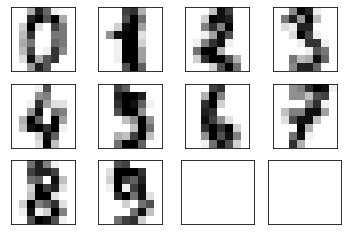

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray() # make plots grey

X = np.absolute(X - 16) # invert colors

fig, ax = plt.subplots(nrows=3, ncols=4)
idx = 0
for i in range(3):
    for j in range(4):
        if idx < 10:      
            image_pixels = X[idx,:]
            image_pixels = np.reshape(image_pixels, (8, -1)) # make the array 8x8
            ax[i, j].imshow(image_pixels)
        ax[i, j].set_xticks([]) # disable ticks on X
        ax[i, j].set_yticks([])# disable ticks on y
        idx += 1     
plt.show()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [3]:
from sklearn.cluster import AgglomerativeClustering, KMeans
kmeans_model = KMeans(n_clusters=10, n_init=100, random_state=2021)
agglomerative_model = AgglomerativeClustering(n_clusters=10)
X_kmeans_clusters = kmeans_model.fit_predict(X)
X_agglomerative_clusters = agglomerative_model.fit_predict(X)
print("KMeans: Shape:", X_kmeans_clusters.shape, "Min value:", np.min(X_kmeans_clusters), \
      "Max value:", np.max(X_kmeans_clusters))
print("AgglomerativeClustering: Shape:", X_agglomerative_clusters.shape, "Min value:", \
      np.min(X_agglomerative_clusters), "Max value:", np.max(X_agglomerative_clusters))

KMeans: Shape: (1797,) Min value: 0 Max value: 9
AgglomerativeClustering: Shape: (1797,) Min value: 0 Max value: 9


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

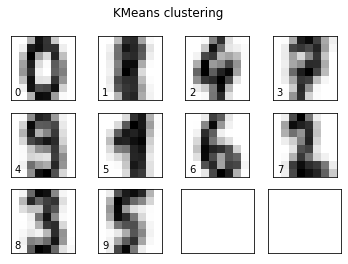

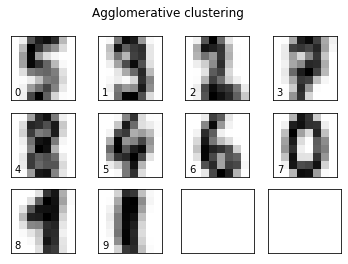

In [4]:
import pandas as pd

def printClusters(X_clustered, plot_title):
    fig, ax = plt.subplots(nrows=3, ncols=4)
    plt.suptitle(plot_title)
    idx = 0
    for i in range(3):
        for j in range(4):
            if idx < 10:
                mask = (X_clustered.index == idx)
                cluster_data = X_clustered[mask].values # select clusters using the mask
                image_pixels = cluster_data.mean(axis=0)
                image_pixels = np.reshape(image_pixels, (8, -1))
                ax[i, j].imshow(image_pixels)
                ax[i, j].text(0,7,idx)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            idx += 1
    plt.show()
    
X_KM_clustered = pd.DataFrame(data=X, index=X_kmeans_clusters) # combine groups of pixels and their groups of pixels  
X_AGG_clustered  = pd.DataFrame(data=X, index=X_agglomerative_clusters)

printClusters(X_KM_clustered, 'KMeans clustering')
printClusters(X_AGG_clustered, 'Agglomerative clustering')

<hr>
In my opinion, both clustering algorithms do a decent job. <br>
If I have to choose one of them, it would be KMeans clustering as "9" looks much better.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

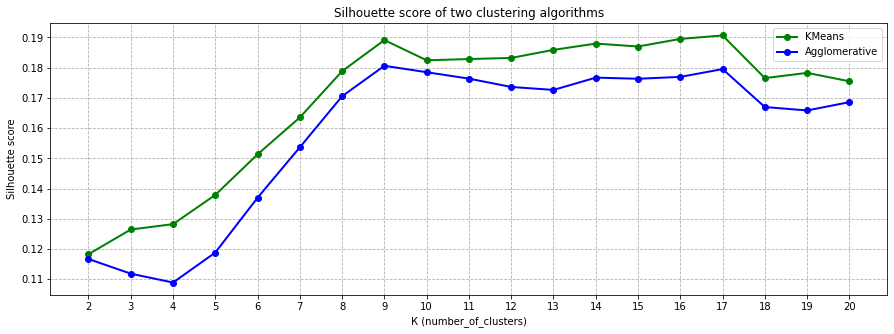

In [5]:
from sklearn.metrics import silhouette_score

silhouette_scores_df = pd.DataFrame(columns=['number_of_clusters', 'KMeans_score', 'Agglomerative_score'])

for clusters_number in range(2,21):
    kmeans_model = KMeans(n_clusters=clusters_number, n_init=100, random_state=2021)
    agglomerative_model = AgglomerativeClustering(n_clusters=clusters_number)
    X_kmeans_clusters = kmeans_model.fit_predict(X)
    X_agglomerative_clusters = agglomerative_model.fit_predict(X)
    Kmeans_score = silhouette_score(X, X_kmeans_clusters, random_state=2021)
    Agglomerative_score = silhouette_score(X, X_agglomerative_clusters, random_state=2021)
    silhouette_scores_df = silhouette_scores_df.append({'number_of_clusters':clusters_number, \
                                 'KMeans_score':Kmeans_score, 'Agglomerative_score':Agglomerative_score},\
                               ignore_index=True)

with plt.rc_context({"figure.figsize": (15,5), 'axes.grid': True, 'grid.linestyle': '--', 'lines.linewidth': 2}): 
    plt.plot(silhouette_scores_df['number_of_clusters'], \
             silhouette_scores_df['KMeans_score'], color='green', marker="o", label='KMeans')
    plt.plot(silhouette_scores_df['number_of_clusters'], \
             silhouette_scores_df['Agglomerative_score'], color='blue', marker="o", label='Agglomerative')
    plt.xlabel('К (number_of_clusters)')
    plt.ylabel('Silhouette score')
    plt.xticks(silhouette_scores_df['number_of_clusters'])
    plt.legend()     
    plt.title('Silhouette score of two clustering algorithms') 
    plt.show()

In [6]:
print(f"The best number of clusters when using Kmeans clustering is {int(silhouette_scores_df.iloc[silhouette_scores_df.KMeans_score.argmax(), 0:1].values)}")
print(f"The best number of clusters when using Agglomerative clustering is {int(silhouette_scores_df.iloc[silhouette_scores_df.Agglomerative_score.argmax(), 0:1].values)}")

The best number of clusters when using Kmeans clustering is 17
The best number of clusters when using Agglomerative clustering is 9


Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

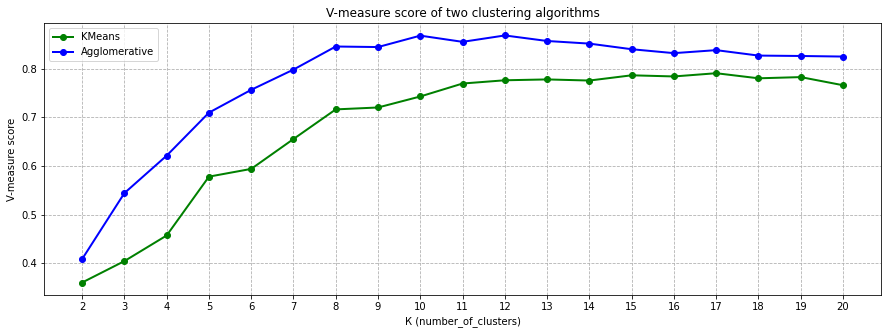

The highest V-measure score when using Kmeans clustering was registered with 17 clusters 
The highest V-measure score when using Agglomerative clustering was registered with 12 clusters


In [7]:
from sklearn.metrics import v_measure_score

v_score_df = pd.DataFrame(columns=['number_of_clusters', 'KMeans_score', 'Agglomerative_score'])

for clusters_number in range(2,21):
    kmeans_model = KMeans(n_clusters=clusters_number, n_init=100, random_state=2021)
    agglomerative_model = AgglomerativeClustering(n_clusters=clusters_number)
    X_kmeans_clusters = kmeans_model.fit_predict(X)
    X_agglomerative_clusters = agglomerative_model.fit_predict(X)
    Kmeans_score = v_measure_score(y, X_kmeans_clusters)
    Agglomerative_score = v_measure_score(y, X_agglomerative_clusters)
    v_score_df = v_score_df.append({'number_of_clusters':clusters_number, \
                                 'KMeans_score':Kmeans_score, 'Agglomerative_score':Agglomerative_score},\
                               ignore_index=True)
      
with plt.rc_context({"figure.figsize": (15,5), 'axes.grid': True, 'grid.linestyle': '--', 'lines.linewidth': 2}): 
    plt.plot(v_score_df['number_of_clusters'], \
             v_score_df['KMeans_score'], color='green', marker="o", label='KMeans')
    plt.plot(v_score_df['number_of_clusters'], \
             v_score_df['Agglomerative_score'], color='blue', marker="o", label='Agglomerative')
    plt.xlabel('К (number_of_clusters)')
    plt.ylabel('V-measure score')
    plt.xticks(v_score_df['number_of_clusters'])
    plt.legend()     
    plt.title('V-measure score of two clustering algorithms') 
    plt.show()
    
print(f"The highest V-measure score when using Kmeans clustering was registered with {int(v_score_df.iloc[v_score_df.KMeans_score.argmax(), 0:1].values)} clusters ")
print(f"The highest V-measure score when using Agglomerative clustering was registered with {int(v_score_df.iloc[v_score_df.Agglomerative_score.argmax(), 0:1].values)} clusters")

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

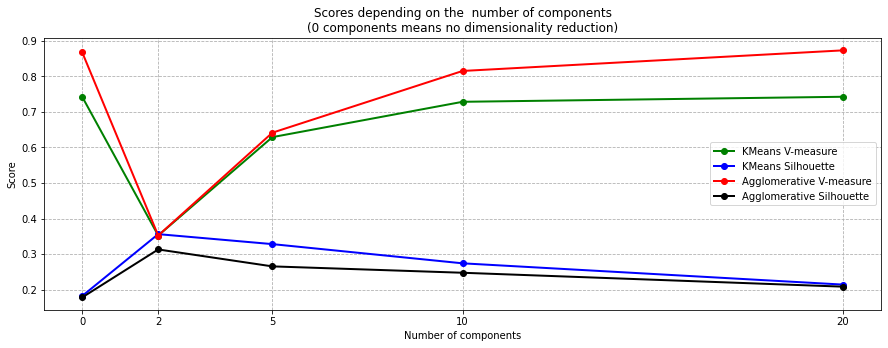

In [8]:
from sklearn.decomposition import TruncatedSVD

tsvd_results = pd.DataFrame(columns=['n_components', 'KMeans_v_score', 'KMeans_s_score', \
                                    'Agg_v_score', 'Agg_s_score'])

kmeans_model = KMeans(n_clusters=10, n_init=100, random_state=2021)
agglomerative_model = AgglomerativeClustering(n_clusters=10)
X_kmeans_clusters = kmeans_model.fit_predict(X)
X_agglomerative_clusters = agglomerative_model.fit_predict(X)
tsvd_results = tsvd_results.append({'n_components': 0, \
                                    'KMeans_v_score': v_measure_score(y, X_kmeans_clusters),\
                                    'KMeans_s_score': silhouette_score(X, X_kmeans_clusters, random_state=2021),\
                                    'Agg_v_score': v_measure_score(y, X_agglomerative_clusters),\
                                    'Agg_s_score': silhouette_score(X, X_agglomerative_clusters, random_state=2021)},\
                                    ignore_index=True)

for components_number in [2, 5, 10, 20]:
    tsvd = TruncatedSVD(n_components=components_number, random_state=2021)
    X_decomposed = tsvd.fit_transform(X)
    X_kmeans_clusters = kmeans_model.fit_predict(X_decomposed)
    X_agglomerative_clusters = agglomerative_model.fit_predict(X_decomposed)
    tsvd_results = tsvd_results.append({'n_components': components_number, \
                                      'KMeans_v_score': v_measure_score(y, X_kmeans_clusters),\
                                      'KMeans_s_score': silhouette_score(X_decomposed, X_kmeans_clusters, random_state=2021),\
                                      'Agg_v_score': v_measure_score(y, X_agglomerative_clusters),\
                                      'Agg_s_score': silhouette_score(X_decomposed, X_agglomerative_clusters, random_state=2021)},\
                                       ignore_index=True)

with plt.rc_context({"figure.figsize": (15,5), 'axes.grid': True, 'grid.linestyle': '--', 'lines.linewidth': 2}): 
    plt.plot(tsvd_results['n_components'], \
             tsvd_results['KMeans_v_score'], color='green', marker="o", label='KMeans V-measure')
    plt.plot(tsvd_results['n_components'], \
             tsvd_results['KMeans_s_score'], color='blue', marker="o", label='KMeans Silhouette')
    plt.plot(tsvd_results['n_components'], \
             tsvd_results['Agg_v_score'], color='red', marker="o", label='Agglomerative V-measure')
    plt.plot(tsvd_results['n_components'], \
             tsvd_results['Agg_s_score'], color='black', marker="o", label='Agglomerative Silhouette')
    plt.xlabel('Number of components')
    plt.ylabel('Score')
    plt.xticks(tsvd_results['n_components'])
    plt.legend()     
    plt.title('Scores depending on the  number of components\n(0 components means no dimensionality reduction)') 
    plt.show()

<hr>
The dimensionality reduction increased Silhoutte scores (with n_components == 2) for both KMeans and Agglomerative clustring algorithms.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

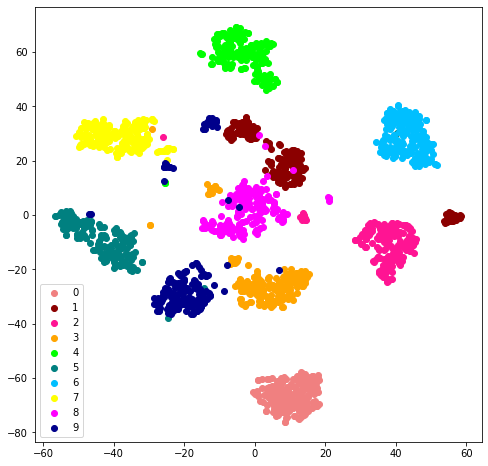

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=2021)
X_tsne = tsne.fit_transform(X)
digit_ids = list(range(0,10))
colors = 'LightCoral', 'DarkRed', 'DeepPink', 'Orange', 'Lime', 'Teal', 'DeepSkyBlue', 'Yellow', 'Magenta', 'DarkBlue'

with plt.rc_context({"figure.figsize": (8,8)}):
    for digit_id, c in zip(digit_ids, colors):
        plt.scatter(X_tsne[y == digit_id, 0], X_tsne[y == digit_id, 1], c=c, label=digit_id)
    plt.legend()
    plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [10]:
X_kmeans_tsne_clusters = kmeans_model.fit_predict(X_tsne)
X_agglomerative_tsne_clusters = agglomerative_model.fit_predict(X_tsne)
print('KMeans Clustering, V-Measure score', v_measure_score(y, X_kmeans_clusters))
print('Agglomerative Clustering, V-Measure score', v_measure_score(y, X_agglomerative_tsne_clusters))
print('KMeans Clustering, Silhoutte score', silhouette_score(X_tsne, X_kmeans_tsne_clusters, random_state=2021))
print('Agglomerative clustering, Silhouette score', silhouette_score(X_tsne, X_agglomerative_tsne_clusters, random_state=2021))

KMeans Clustering, V-Measure score 0.7425963629564275
Agglomerative Clustering, V-Measure score 0.909384579346888
KMeans Clustering, Silhoutte score 0.6356844
Agglomerative clustering, Silhouette score 0.63582355


<hr>
Silhoutte score is significantly higher; V-measure score of Agglomerative clustering was slightly improved (I'm not sure if I should use the original X dataset or X_tsne when measuring Silhouette though).

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

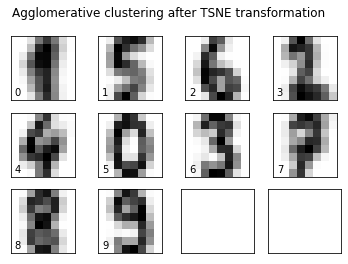

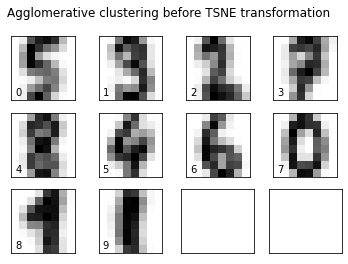

In [11]:
X_AGG_tsne_clustered  = pd.DataFrame(data=X, index=X_agglomerative_tsne_clusters)

printClusters(X_AGG_tsne_clustered, 'Agglomerative clustering after TSNE transformation')
printClusters(X_AGG_clustered, 'Agglomerative clustering before TSNE transformation')

<hr>
Agglomerative clustering, even without TSNE transformation, made a decent job in clustering.<br>
Hovewer, afer applying TSNE algorithm, silhouttes of digits became more distinct - it's clearly seen if we look at "9".

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

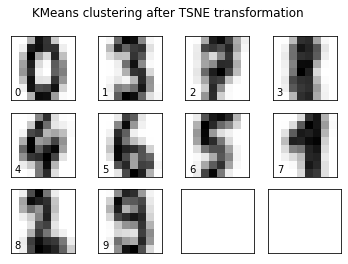

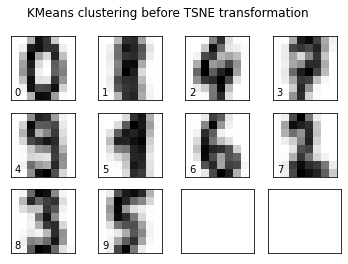

In [12]:
X_KMeans_tsne_clustered  = pd.DataFrame(data=X, index=X_kmeans_clusters)

printClusters(X_KMeans_tsne_clustered, 'KMeans clustering after TSNE transformation')
printClusters(X_KM_clustered, 'KMeans clustering before TSNE transformation')

<hr>
1. In my opinion, if I use the original 'raw' data, visualized centroids of K-means clustering look more clear than those generated by Agglomerative clustering.<br>
The quality of predictions does depend on the number of clusters that I choose, so that's the primary parameter I need to pay attention to and that's when Silhoutte score comes in handy - using the 'elbow' approach, I could predict the proper number of clusters looking at the graph demonstrating the dependency of the score on the number of clusters. <br>
2. TSNE improves scores, especially for Agglomerative clustering. After transforming the data using dimension reduction pictures of 'average' digits in clusters became more distinguishable.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [13]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.to_numpy().astype(int)
X = np.absolute(X - 255) # invert colors
y = y.to_numpy().astype(int)

<hr>
Disclaimer: taking into account that V-measure score is penalized when there are unnecessary splits (in other words, if we have 10 digits and 30 clusters, and each cluster perfectly predicts digits, the V-measure score will be penalized due to the loss of completness). Thus, there is no use in trying high numbers of clusters as V-measure score will decrease anyway due to excessive splits.

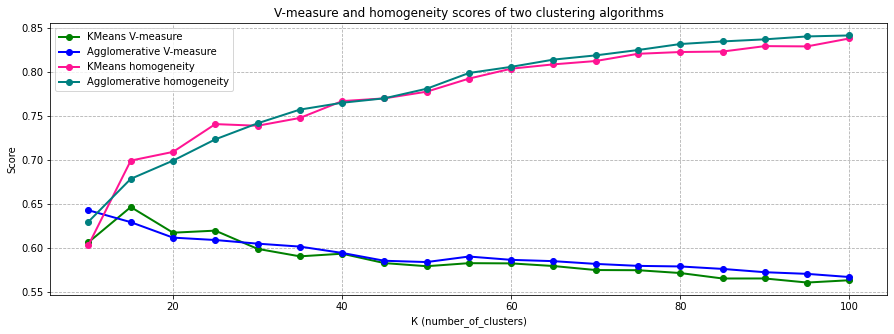

In [14]:
# first things first - get the best number of clusters using a small part of the source data set
from sklearn.metrics import homogeneity_score, accuracy_score
X_part = X[0:2000,:]
y_part = y[0:2000]

X_part = np.around(X_part/16) # reduce the number of colors - make it 16 instead of 256
tsne = TSNE(n_components=2, random_state=2021)
X_part = tsne.fit_transform(X_part)

scores_df = pd.DataFrame(columns=['number_of_clusters', 'KMeans_score', 'Agglomerative_score',\
                                 'KMeans_homogeneity', 'Agglomerative_homogeneity'])

for clusters_number in range(10,101,5):
    kmeans_model = KMeans(n_clusters=clusters_number, n_init=100, random_state=2021)
    agglomerative_model = AgglomerativeClustering(n_clusters=clusters_number)
    X_kmeans_clusters = kmeans_model.fit_predict(X_part)
    X_agglomerative_clusters = agglomerative_model.fit_predict(X_part)
    Kmeans_score = v_measure_score(y_part, X_kmeans_clusters)
    Agglomerative_score = v_measure_score(y_part, X_agglomerative_clusters)
    KMeans_h_score = homogeneity_score(y_part, X_kmeans_clusters)
    Agglomerative_h_score = homogeneity_score(y_part, X_agglomerative_clusters)
    scores_df = scores_df.append({'number_of_clusters':clusters_number,\
                                    'KMeans_score':Kmeans_score, 'Agglomerative_score':Agglomerative_score,\
                                    'KMeans_homogeneity': KMeans_h_score, 'Agglomerative_homogeneity': Agglomerative_h_score},\
                                   ignore_index=True)
with plt.rc_context({"figure.figsize": (15,5), 'axes.grid': True, 'grid.linestyle': '--', 'lines.linewidth': 2}): 
    plt.plot(scores_df['number_of_clusters'], \
             scores_df['KMeans_score'], color='green', marker="o", label='KMeans V-measure')
    
    plt.plot(scores_df['number_of_clusters'], \
             scores_df['Agglomerative_score'], color='blue', marker="o", label='Agglomerative V-measure')
    
    plt.plot(scores_df['number_of_clusters'], \
             scores_df['KMeans_homogeneity'], color='DeepPink', marker="o", label='KMeans homogeneity')
    
    plt.plot(scores_df['number_of_clusters'], \
             scores_df['Agglomerative_homogeneity'], color='Teal', marker="o", label='Agglomerative homogeneity')
    
    plt.xlabel('К (number_of_clusters)')
    plt.ylabel('Score')
    plt.legend()     
    plt.title('V-measure and homogeneity scores of two clustering algorithms') 
    plt.show()

<hr>
The most optimal number of clusters seems to be 10 for Agglomerative clustering and 15 for Kmeans - there's no surpise, similar values were discovered with another digits dataset we used before.<br>
Also, the interesting thing is that homogenity increases when I increase the number of clusters - predictions become more accurate.

In [15]:
# to find out the accuracy of predictions, I add two functions that set correct labels (predicted digits) for clusters
def link_clusters_and_labels(clustering_model, original_labels):
    clusters_and_labels = {} # a dictionary to store relations between clusters and their correct labels
    for cluster_id in range(clustering_model.n_clusters): # replace with 
        cluster_indeces = np.where(clustering_model.labels_ == cluster_id) # get indeces of all elements in this cluster
        labels = original_labels[cluster_indeces].astype(int) # get original labels of elements with indeces above 
        counts = np.bincount(labels) # get bincount (count of each digit [0...9] found in the array)
        most_frequent_label = np.argmax(counts) # find the most frequent label in the cluster
        # calculate how many times the label (digit) can be found in the cluster
        best_label_count = np.count_nonzero(labels == most_frequent_label) 
        count_of_all_elements_in_cluster = len(labels) # total number of elements in the cluster
        # get the ratio of the most frequent digit to other digits (labels) in the cluster
        percentage_of_best_label = round(100*(best_label_count/count_of_all_elements_in_cluster), 0)
        if most_frequent_label in clusters_and_labels: # add the claster to the list of labels
            # if there is a cluster linked to the label, append the cluster to the list of exising clusters
            clusters_and_labels[most_frequent_label].append(cluster_id)   
        else:
            clusters_and_labels[most_frequent_label] = [cluster_id]
        #print('cluster: {}, digit: {}, count: {}, ratio: {}%'\
        #      .format(cluster_id, most_frequent_label, count_of_all_elements_in_cluster, percentage_of_best_label))
    return clusters_and_labels

def set_proper_data_labels(X_labels, cluster_labels):
    proper_predicted_labels = np.zeros(len(X_labels)).astype(int) # create a template to store predicted labels(digits)
    for i, cluster in enumerate(X_labels): # iterate over clusters
        for key, value in cluster_labels.items(): # iterate over the dictionary with labels and their clasters
            if cluster in value:
                proper_predicted_labels[i] = key              
    return proper_predicted_labels

In [16]:
X_scaled = np.around(X/16)
tsne = TSNE(n_components=2, random_state=2021)
X_scaled = tsne.fit_transform(X_scaled)
x_scaled_part = X_scaled[0:20000] # it takes ages to fit 70k records on my laptop, so I decided to fit first 20k records only

km_model = KMeans(n_clusters=15, n_init=100, random_state=2021)
km_model.fit(x_scaled_part)
X_km_clusters = km_model.predict(X_scaled)
clusters_and_labels = link_clusters_and_labels(km_model, y)
y_pred_km = set_proper_data_labels(X_km_clusters, clusters_and_labels)
print('K-Means: V-measure score', v_measure_score(y, X_km_clusters))
print('K-Means: Silhoutte score', silhouette_score(X_scaled, X_km_clusters, random_state=2021))
print('K-Means: homogenity score', homogeneity_score(y, X_km_clusters))
print('K-Means: accuracy', accuracy_score(y, y_pred_km))

K-Means: V-measure score 0.7307593905420074
K-Means: Silhoutte score 0.3840817
K-Means: homogenity score 0.7926438180306972
K-Means: accuracy 0.8201857142857143


In [19]:
agg_model = AgglomerativeClustering(n_clusters=10)
y_part = y[:20000]
X_scaled_part = X_scaled[:20000] # I waited for a couple of hours but my laptop couldn't process 70k
X_agg_clusters = agg_model.fit_predict(X_scaled_part)
clusters_and_labels = link_clusters_and_labels(agg_model, y_part)
y_pred_agg = set_proper_data_labels(X_agg_clusters, clusters_and_labels)

print('Agglomerative: V-measure score', v_measure_score(y_part, X_agg_clusters))
print('Agglomerative: Silhoutte score', silhouette_score(X_scaled_part, X_agg_clusters, random_state=2021))
print('Agglomerative: homogenity score', homogeneity_score(y_part, X_agg_clusters))
print('Agglomerative: accuracy', accuracy_score(y_part, y_pred_agg))

Agglomerative: V-measure score 0.7472267478012602
Agglomerative: Silhoutte score 0.35697815
Agglomerative: homogenity score 0.7433413944934649
Agglomerative: accuracy 0.74475
